# Implementation For Europe
## State Variable:

- Prices: Euro Stoxx 50 (Bloomberg)
- Volatility: realised + Implied on Euro Stoxx 50
- 10 year rate: 10 year german bond (assumed that german bond is a benchmark for europe) (FRED)
- 3 month rate: 3 month German bond (FRED)
- Oil: brent crude oil futures (Bloomberg)
- Copper: Copper future prices (Bloomberg)

Used also Fama French Factors to evaluate the performance for now,

## Results: 
The signal seems to hold in this market too, Maha distance seems also to contribute to better performance (higher SR) and also clearer economic interpretation giving more performance from first quantile.

In [123]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import seaborn as sns
data = pd.read_excel("Regimes\Data\Europe\europe state variable.xlsx")
fred_3m = (pd.read_excel("Regimes\Data\Europe\Germ3m.xlsx").rename(columns={
                              "Germ3m": "ThreeMonth"}))               
fred_3m["Date"]       = pd.to_datetime(fred_3m["Date"])
fred_3m["ThreeMonth"] = pd.to_numeric(fred_3m["ThreeMonth"], errors="coerce")
fred_3m["Month"]      = fred_3m["Date"].dt.to_period("M")

fred_10y = (pd.read_excel("Regimes\Data\Europe\Germ10y.xlsx")      
              .rename(columns={"10y": "TenYear"}))

fred_10y["Date"]   = pd.to_datetime(fred_10y["Date"])
fred_10y["TenYear"] = pd.to_numeric(fred_10y["TenYear"], errors="coerce")
fred_10y["Month"]  = fred_10y["Date"].dt.to_period("M")


non_date_cols = [c for c in data.columns if c != "Dates"]

data = data.dropna(axis=0, how="all", subset=non_date_cols)
data.head()

,Dates,Euro_Stoxx_Price,Germ10y,Germ3m,Brent_Crude_Oil_future,Copper_future,Copper_future_2,Euribor3m,Vol_Euro_Stoxx
15132,1986-12-31,900.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15133,1987-01-01,900.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15134,1987-01-02,891.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15135,1987-01-05,898.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15136,1987-01-06,902.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN


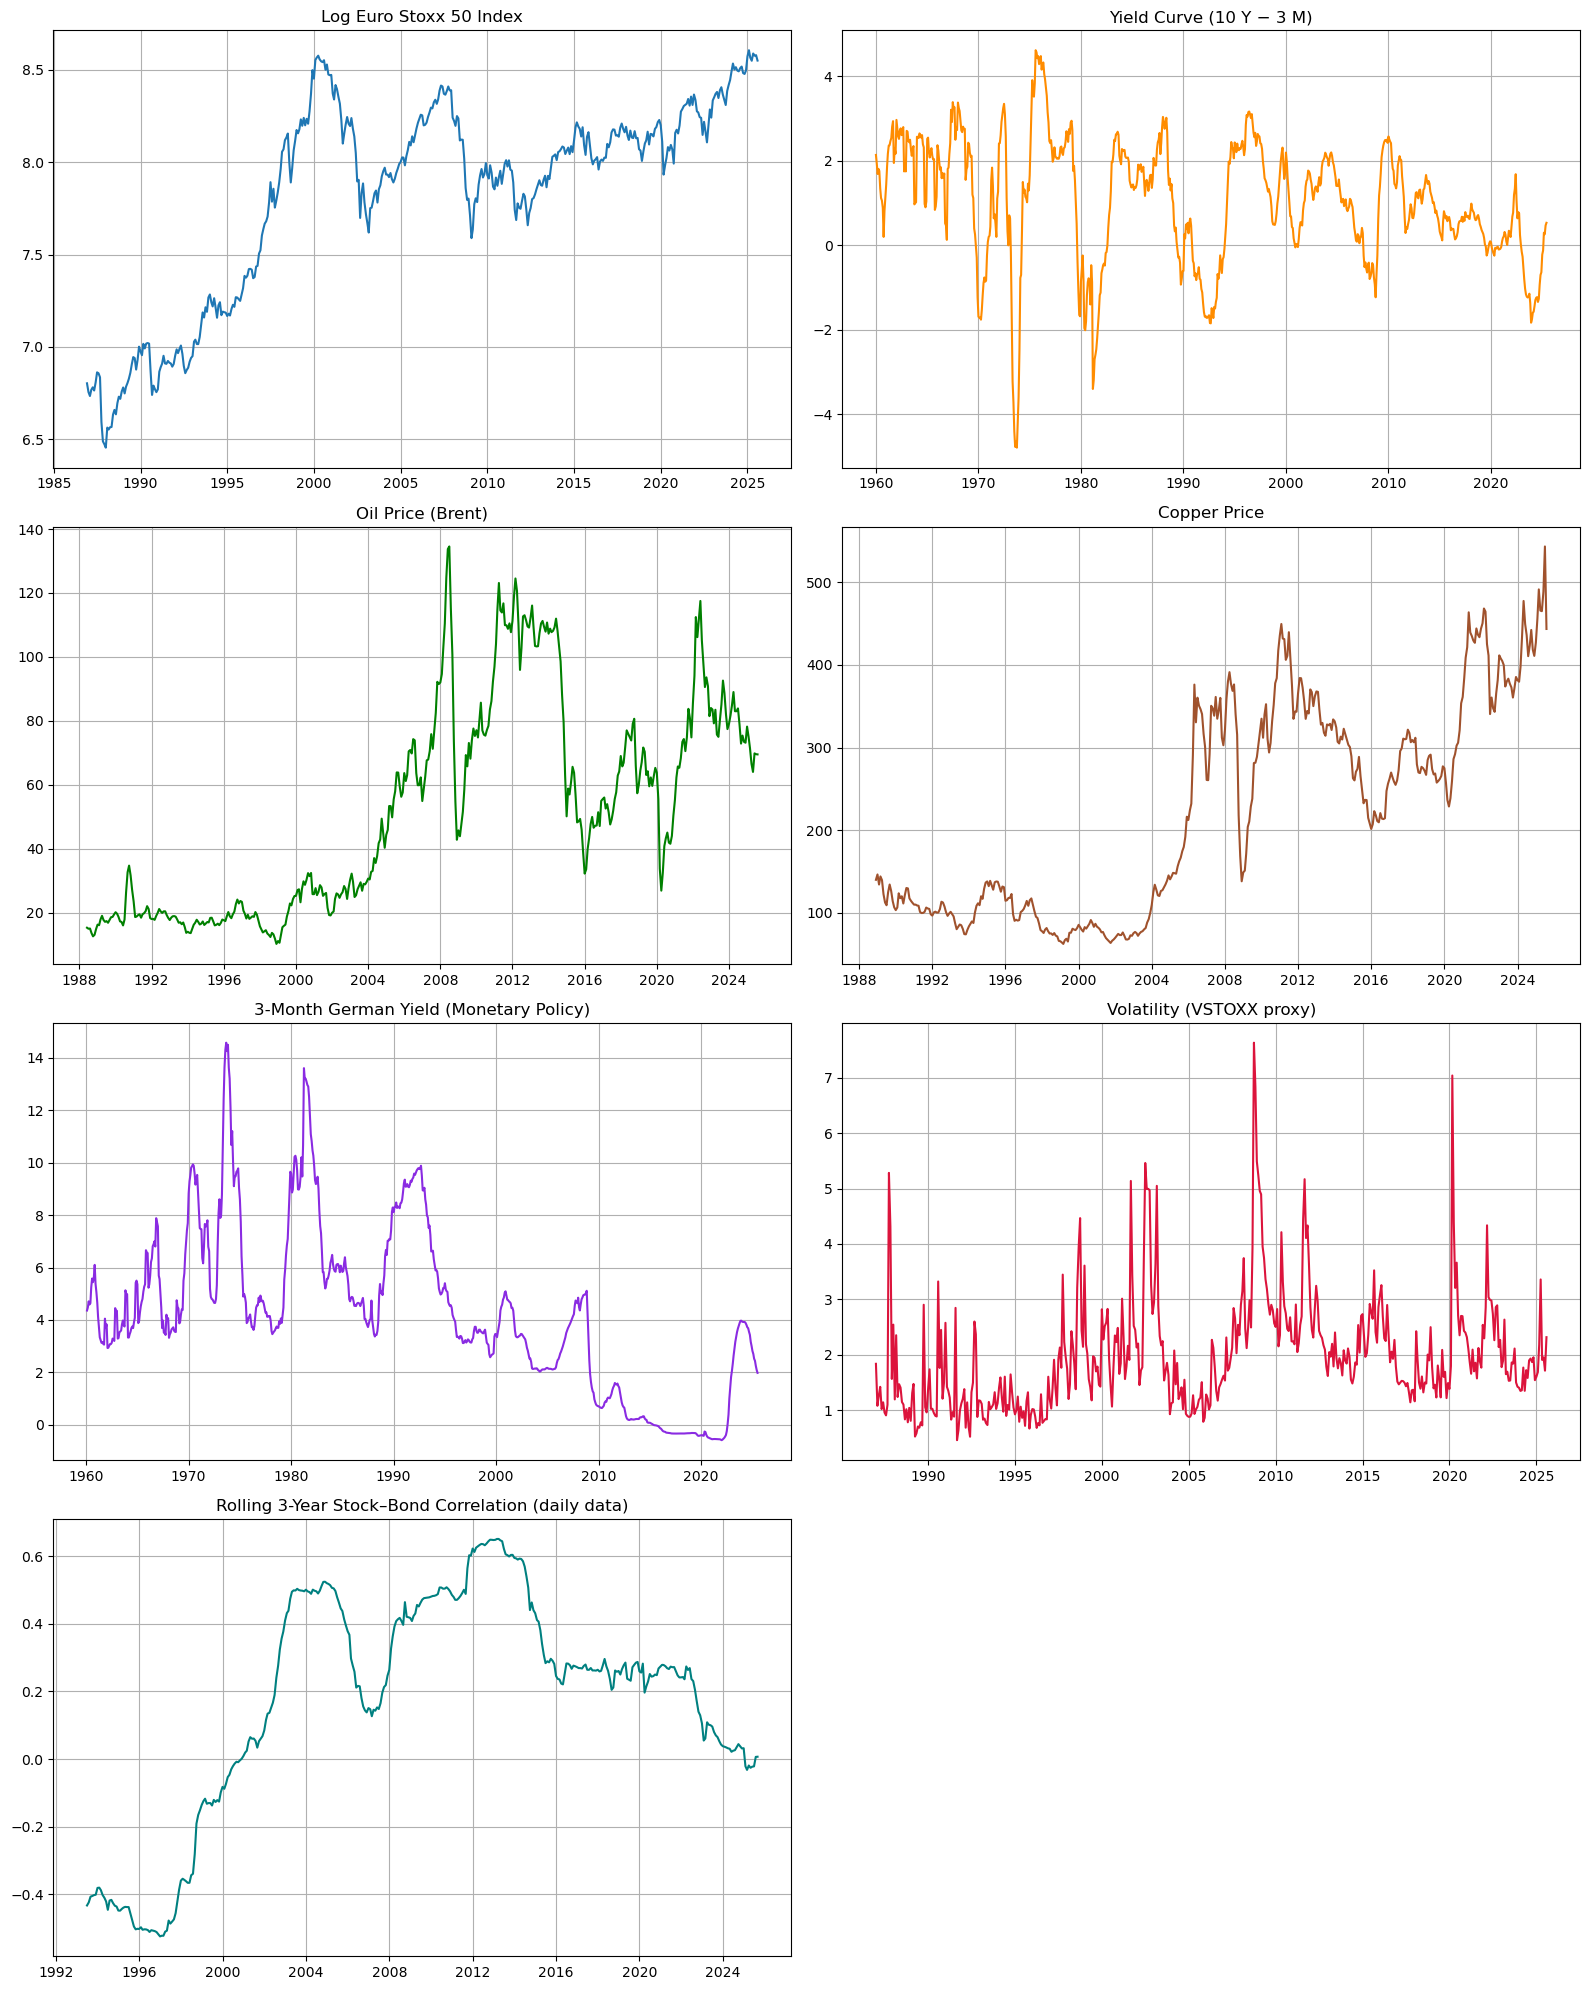

In [108]:
df = data.copy().rename(columns={"Dates": "Date"})
df["Date"] = pd.to_datetime(df["Date"])

# ----------------------------------------------------------------------
# 1. Euro Stoxx 50 (daily ➜ monthly prices & returns)
# ----------------------------------------------------------------------
df["ret"] = np.log(df["Euro_Stoxx_Price"]).diff()
df["Month"] = df["Date"].dt.to_period("M")

eurostoxx_monthly = (df.groupby("Month")
                       .tail(1)
                       .reset_index(drop=True))

eurostoxx_monthly["EuroStoxx_Return"] = np.log(eurostoxx_monthly["Euro_Stoxx_Price"]).diff()
eurostoxx_monthly["Log_EuroStoxx"] = np.log(eurostoxx_monthly["Euro_Stoxx_Price"])

var_mkt_eur = eurostoxx_monthly[["Month", "Euro_Stoxx_Price",
                                 "EuroStoxx_Return", "Log_EuroStoxx"]].copy()

# ----------------------------------------------------------------------
# 2. German 10-Year Yield (daily ➜ monthly)
# ----------------------------------------------------------------------
tenyear_monthly = (fred_10y
                     .groupby("Month")["TenYear"]
                     .mean()
                     .reset_index())

# ----------------------------------------------------------------------
# 3. German 3-Month Yield (daily ➜ monthly)
# ----------------------------------------------------------------------
var_3m_eur = (fred_3m
                .groupby("Month")["ThreeMonth"]
                .mean()
                .reset_index())    

# ----------------------------------------------------------------------
# 4. Yield-Curve Variables
# ----------------------------------------------------------------------
merged_eur = (tenyear_monthly
                .merge(var_3m_eur, on="Month", how="inner")
                .sort_values("Month"))

merged_eur["YieldCurve"]  = merged_eur["TenYear"] - merged_eur["ThreeMonth"]
merged_eur["YieldChange"] = merged_eur["TenYear"].diff()


# ----------------------------------------------------------------------
# 5. Brent Crude Oil (monthly average)
# ----------------------------------------------------------------------
df["Brent_Crude_Oil_future "] = pd.to_numeric(df["Brent_Crude_Oil_future "], errors="coerce")
oil_monthly_eur = (df.groupby("Month")["Brent_Crude_Oil_future "]
                     .mean()
                     .reset_index()
                     .rename(columns={"Brent_Crude_Oil_future ": "Oil Price"}))

# ----------------------------------------------------------------------
# 6. Copper (monthly average)
# ----------------------------------------------------------------------
df["Copper_future"] = pd.to_numeric(df["Copper_future"], errors="coerce")
df["Copper_future_2"] = pd.to_numeric(df["Copper_future_2"], errors="coerce")

copper_monthly_eur = (df.groupby("Month")["Copper_future"]
                        .mean()
                        .reset_index()
                        .rename(columns={"Copper_future": "Copper"}))
# ----------------------------------------------------------------------
# 6. Volatility
# ----------------------------------------------------------------------
vix_monthly_eur = (df.groupby("Month")["Vol_Euro_Stoxx"]
                     .mean()
                     .div(10)                  
                     .rename("VolProxy")
                     .dropna()             
                     .reset_index())

first_vol_month_eur = vix_monthly_eur["Month"].min()

realised_eur = (
    df.loc[df["Month"] < first_vol_month_eur]
      .groupby("Month")["ret"]
      .agg(lambda x: x.std(ddof=0) * np.sqrt(252) * 10)   
      .to_frame("VolProxy")
      .reset_index()
)

combined_vol_eur = (pd.concat([realised_eur, vix_monthly_eur], axis=0)
                      .sort_values("Month")
                      .reset_index(drop=True))


# ----------------------------------------------------------------------
# 8. Stock–Bond Correlation (daily ➜ monthly)
# ----------------------------------------------------------------------
df_daily_eur = df[["Date", "ret", "Germ10y"]].dropna().copy()
df_daily_eur["d_y"] = df_daily_eur["Germ10y"].diff() / 100.0
df_daily_eur.dropna(inplace=True)

window_days = 252 * 3
df_daily_eur["StockBondCorr"] = (df_daily_eur["ret"]
                                   .rolling(window_days)
                                   .corr(df_daily_eur["d_y"]))

df_daily_eur["Month"] = df_daily_eur["Date"].dt.to_period("M")
var_correl_eur = (df_daily_eur.dropna(subset=["StockBondCorr"])
                    .groupby("Month")
                    .tail(1)
                    [["Month", "StockBondCorr"]]
                    .reset_index(drop=True))
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axes = axes.flatten()

# 1. Log Euro Stoxx 50
var_mkt_latest_eur = var_mkt_eur.drop_duplicates("Month", keep="last")
axes[0].plot(
    var_mkt_latest_eur["Month"].dt.to_timestamp(),
    np.log(var_mkt_latest_eur["Euro_Stoxx_Price"]),
    label="Log Euro Stoxx 50"
)
axes[0].set_title("Log Euro Stoxx 50 Index")
axes[0].grid()

# 2. Yield Curve (10 Y − 3 M)
axes[1].plot(
    merged_eur["Month"].dt.to_timestamp(),
    merged_eur["YieldCurve"],
    label="Yield Curve",
    color="darkorange"
)
axes[1].set_title("Yield Curve (10 Y − 3 M)")
axes[1].grid()

# 3. Brent Crude Oil 
axes[2].plot(
    oil_monthly_eur["Month"].dt.to_timestamp(),
    oil_monthly_eur["Oil Price"],
    label="Oil Price",
    color="green"
)
axes[2].set_title("Oil Price (Brent)")
axes[2].grid()

# 4. Copper Price 
axes[3].plot(
    copper_monthly_eur["Month"].dt.to_timestamp(),
    copper_monthly_eur["Copper"],
    label="Copper Price",
    color="sienna"
)
axes[3].set_title("Copper Price")
axes[3].grid()

# 5. 3-Month German
axes[4].plot(
    var_3m_eur["Month"].dt.to_timestamp(how="end"),
    var_3m_eur["ThreeMonth"],
    label="3 M Yield",
    color="blueviolet"
)
axes[4].set_title("3-Month German Yield (Monetary Policy)")
axes[4].grid()

# 6. Volatility (Euro Stoxx VSTOXX proxy)
axes[5].plot(
    combined_vol_eur["Month"].dt.to_timestamp(),
    combined_vol_eur["VolProxy"],
    label="Vol Proxy",
    color="crimson"
)
axes[5].set_title("Volatility (VSTOXX proxy)")
axes[5].grid()
    
# 7. Rolling 3-Year Stock–Bond Correlation
axes[6].plot(
    var_correl_eur["Month"].dt.to_timestamp(how="end"),
    var_correl_eur["StockBondCorr"],
    label="Stock–Bond Corr.",
    color="teal"
)
axes[6].set_title("Rolling 3-Year Stock–Bond Correlation (daily data)")
axes[6].grid()
    
# 8. (empty)
axes[7].axis("off")
    
plt.tight_layout()
plt.show()


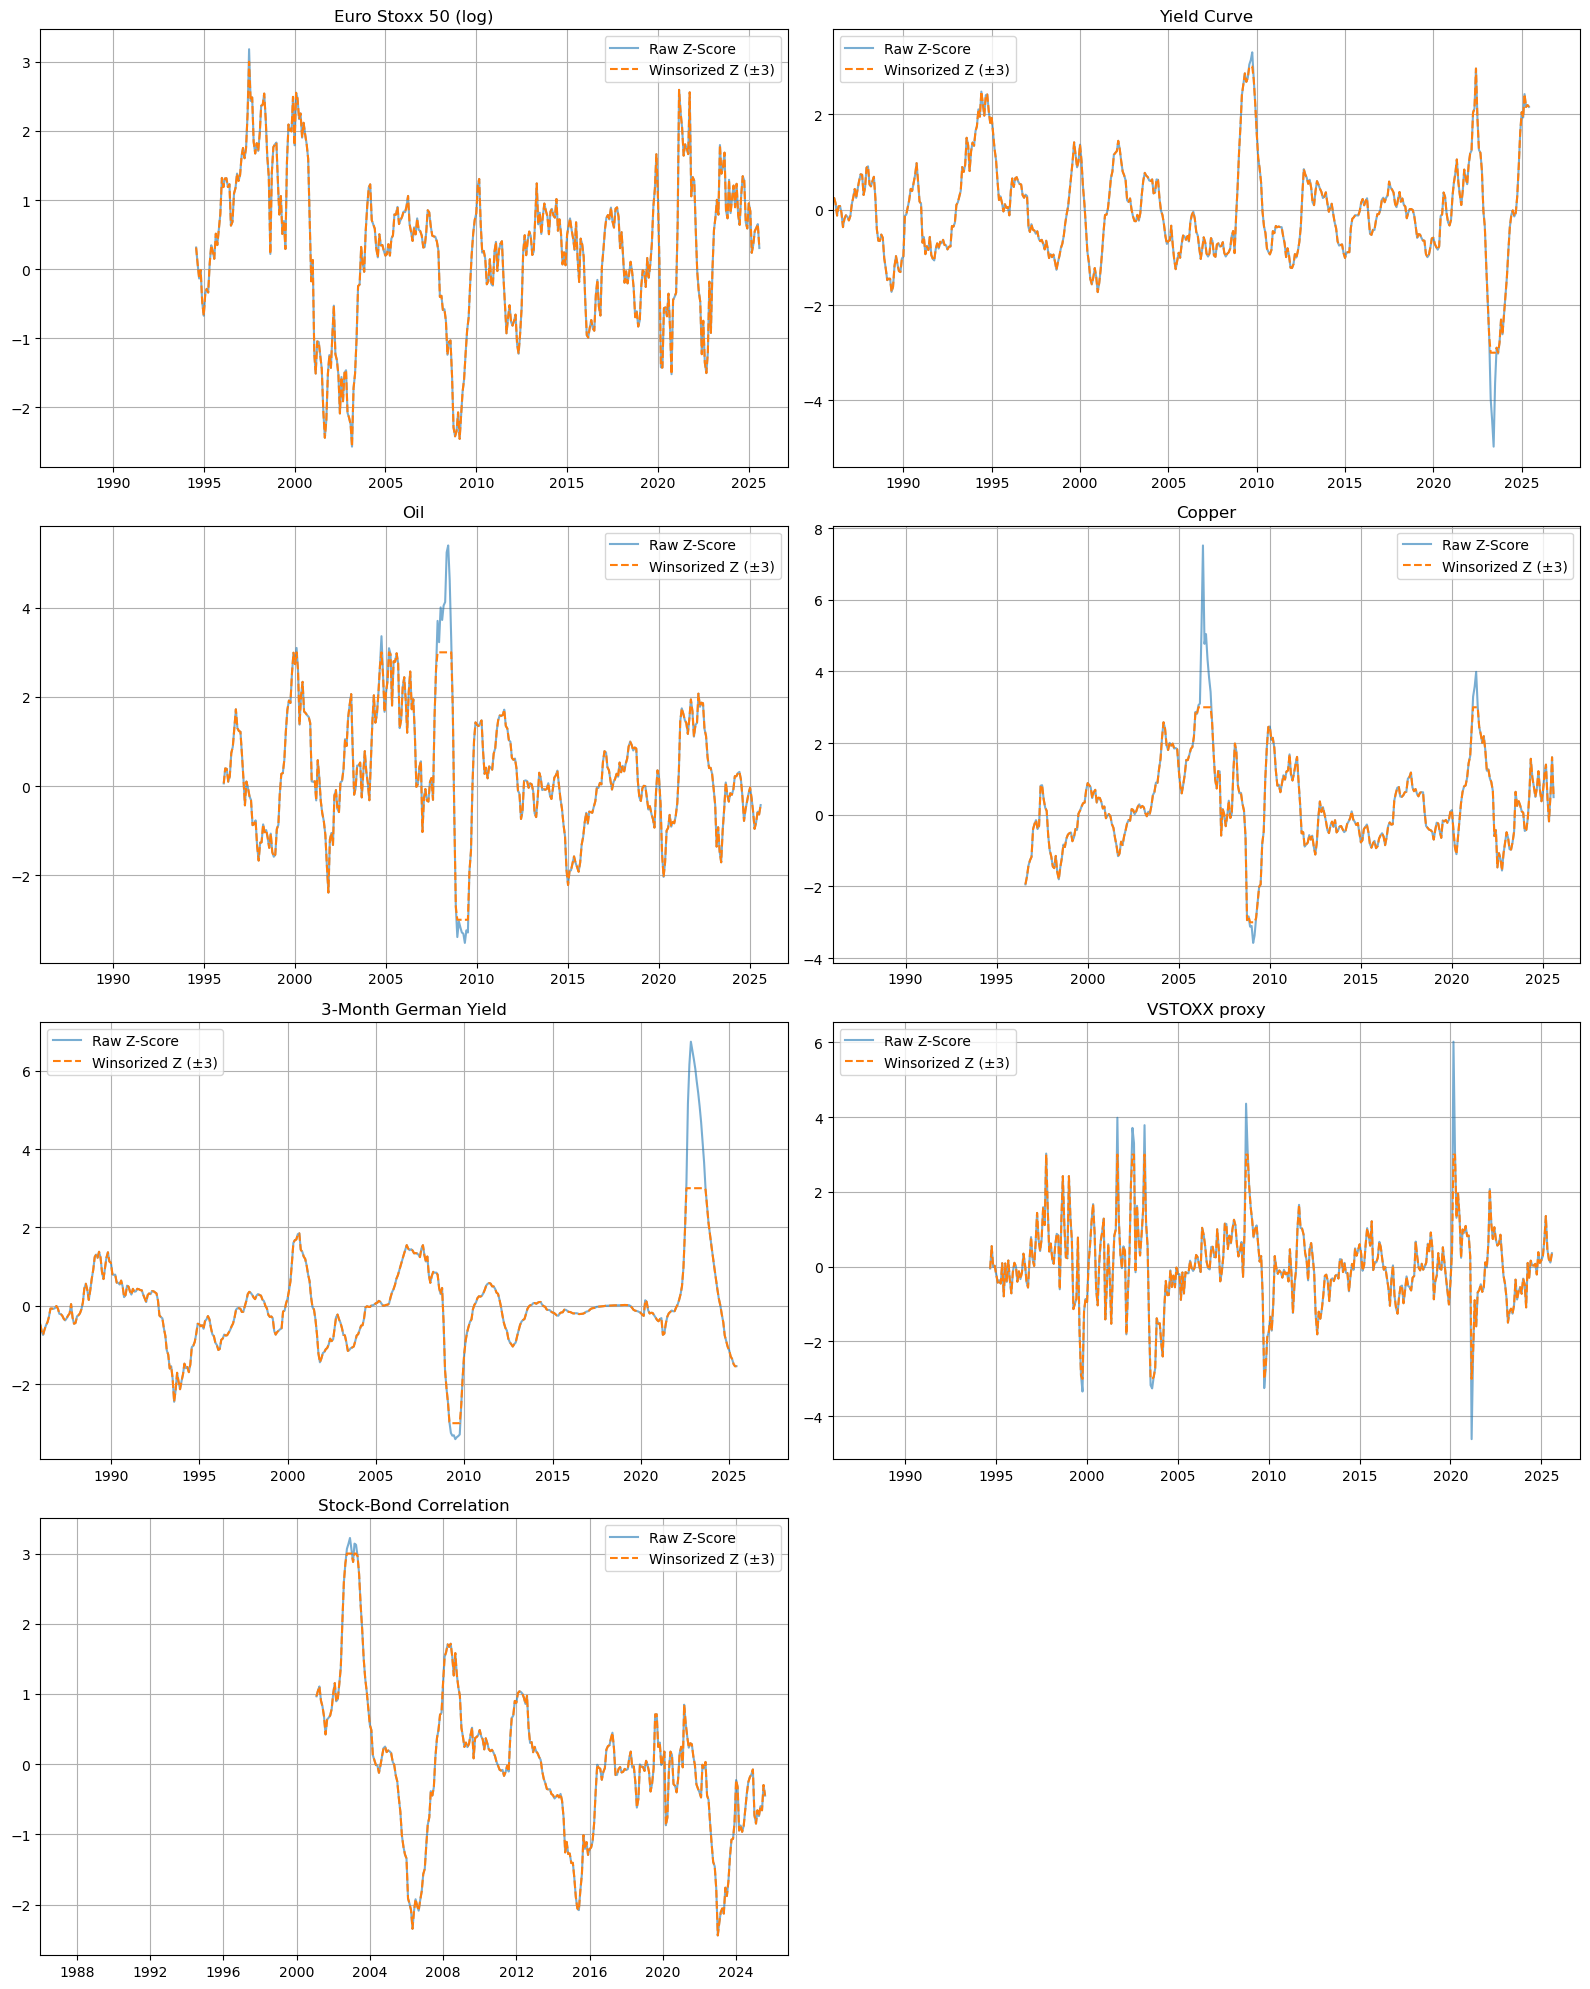

In [109]:
def compute_z_and_winsorized(df, date_col, value_col, window_months=120):
    df = df.copy().sort_values(date_col)
    df["Diff12"]   = df[value_col] - df[value_col].shift(12)
    df["RollStd"]  = (df["Diff12"]
                      .shift(1)
                      .rolling(window_months, min_periods=80)
                      .std())
    df["ZScore"]   = df["Diff12"] / df["RollStd"]
    df["ZScoreWinsorized"] = df["ZScore"].clip(-3, 3)
    return df[[date_col, "ZScore", "ZScoreWinsorized"]]

series_info_eur = {
    "Euro Stoxx 50 (log)":    ("eurostoxx_log",   var_mkt_eur,   "Month", "Log_EuroStoxx"),
    "Yield Curve":            ("yield_curve",     merged_eur,    "Month", "YieldCurve"),
    "Oil":                    ("oil",             oil_monthly_eur,"Month", "Oil Price"),
    "Copper":                 ("copper",          copper_monthly_eur,"Month","Copper"),
    "3-Month German Yield":   ("three_month",     var_3m_eur,    "Month", "ThreeMonth"),
    "VSTOXX proxy":           ("vstoxx",          combined_vol_eur,"Month","VolProxy"),
    "Stock-Bond Correlation": ("stockbond_corr",  var_correl_eur,"Month", "StockBondCorr"),
}

fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

for i, (title, (_, df, date_col, value_col)) in enumerate(series_info_eur.items()):
    z_df = compute_z_and_winsorized(df, date_col, value_col)
    axes[i].plot(z_df[date_col].dt.to_timestamp(), z_df["ZScore"],
                 label="Raw Z-Score", alpha=0.6)
    axes[i].plot(z_df[date_col].dt.to_timestamp(), z_df["ZScoreWinsorized"],
                 label="Winsorized Z (±3)", ls="--")
    axes[i].set_title(title)
    axes[i].set_xlim(left=pd.Timestamp("1986-01-01"))
    axes[i].grid(True)
    axes[i].legend()

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [112]:
market_monthly_eur = (var_mkt_eur
    .loc[:, ["Month", "Log_EuroStoxx"]]
    .rename(columns={"Log_EuroStoxx": "Value"}))

yield_monthly_eur  = (merged_eur
    .loc[:, ["Month", "YieldCurve"]]
    .rename(columns={"YieldCurve": "Value"}))

oil_monthly_clean_eur    = oil_monthly_eur.rename(columns={"Oil Price": "Value"})
copper_monthly_clean_eur = copper_monthly_eur.rename(columns={"Copper": "Value"})

monthly_3m_eur  = (var_3m_eur
    .loc[:, ["Month", "ThreeMonth"]]
    .rename(columns={"ThreeMonth": "Value"}))

vix_monthly_clean_eur = combined_vol_eur.rename(columns={"VolProxy": "Value"})

stockbond_monthly_eur = (var_correl_eur
    .loc[:, ["Month", "StockBondCorr"]]
    .rename(columns={"StockBondCorr": "Value"}))

series_dict_eur = {
    "Market":              market_monthly_eur,
    "Yield curve":         yield_monthly_eur,
    "Oil":                 oil_monthly_clean_eur,
    "Copper":              copper_monthly_clean_eur,
    "3-M German Yield":    monthly_3m_eur,
    "VSTOXX proxy":        vix_monthly_clean_eur,
    "Stock-Bond Corr":     stockbond_monthly_eur,
}


series_info_eur = {
    "Euro Stoxx 50 (log)": ("eurostoxx_log",   var_mkt_eur,   "Month", "Log_EuroStoxx"),
    "Yield curve":         ("yield_curve",     merged_eur,    "Month", "YieldCurve"),
    "Oil":                 ("oil",             oil_monthly_eur,"Month","Oil Price"),
    "Copper":              ("copper",          copper_monthly_eur,"Month","Copper"),
    "3-M German Yield":    ("three_month",     var_3m_eur,    "Month", "ThreeMonth"),
    "VSTOXX proxy":        ("vstoxx",          combined_vol_eur,"Month","VolProxy"),
    "Stock-Bond Corr":     ("stockbond_corr",  var_correl_eur,"Month", "StockBondCorr"),
}

rows   = []
lags   = [1, 3, 12, 36, 120]  
for title, (_, df, date_col, value_col) in series_info_eur.items():

    zdf = (compute_z_and_winsorized(df, date_col, value_col)
           .dropna(subset=["ZScoreWinsorized"])
           .reset_index(drop=True))

    if len(zdf) < max(lags) + 1:
        acs      = [np.nan] * len(lags)
        mean_z   = np.nan
        std_z    = np.nan
    else:
        acs      = [zdf["ZScoreWinsorized"].autocorr(lag=l) for l in lags]
        mean_z   = zdf["ZScoreWinsorized"].mean()
        std_z    = zdf["ZScoreWinsorized"].std(ddof=1)

    rows.append({
        "Variable":     title,
        "1 month":      acs[0],
        "3 month":      acs[1],
        "12 month":     acs[2],
        "3 year":       acs[3],
        "10 year":      acs[4],
        "monthly mean": mean_z,
        "std":          std_z,
        "frequency":    "monthly",
    })

summary_table_eur = (pd.DataFrame(rows)
    .loc[:, ["Variable", "1 month", "3 month", "12 month",
             "3 year", "10 year", "monthly mean", "std", "frequency"]])

numeric_cols = ["1 month", "3 month", "12 month", "3 year",
                "10 year", "monthly mean", "std"]
summary_table_eur[numeric_cols] = summary_table_eur[numeric_cols].round(2)

summary_table_eur

,Variable,1 month,3 month,12 month,3 year,10 year,monthly mean,std,frequency
0,Euro Stoxx 50 (log),0.93,0.79,0.10,-0.17,0.06,0.29,1.08,monthly
1,Yield curve,0.96,0.82,-0.15,0.06,-0.07,-0.04,1.11,monthly
2,Oil,0.93,0.74,-0.14,0.11,-0.10,0.28,1.32,monthly
3,Copper,0.95,0.79,0.04,-0.02,-0.04,0.25,1.18,monthly
4,3-M German Yield,0.98,0.88,0.10,-0.00,0.12,-0.01,1.08,monthly
5,VSTOXX proxy,0.73,0.34,-0.32,-0.02,0.16,0.04,1.02,monthly
6,Stock-Bond Corr,0.98,0.90,0.38,-0.37,0.31,-0.03,1.05,monthly


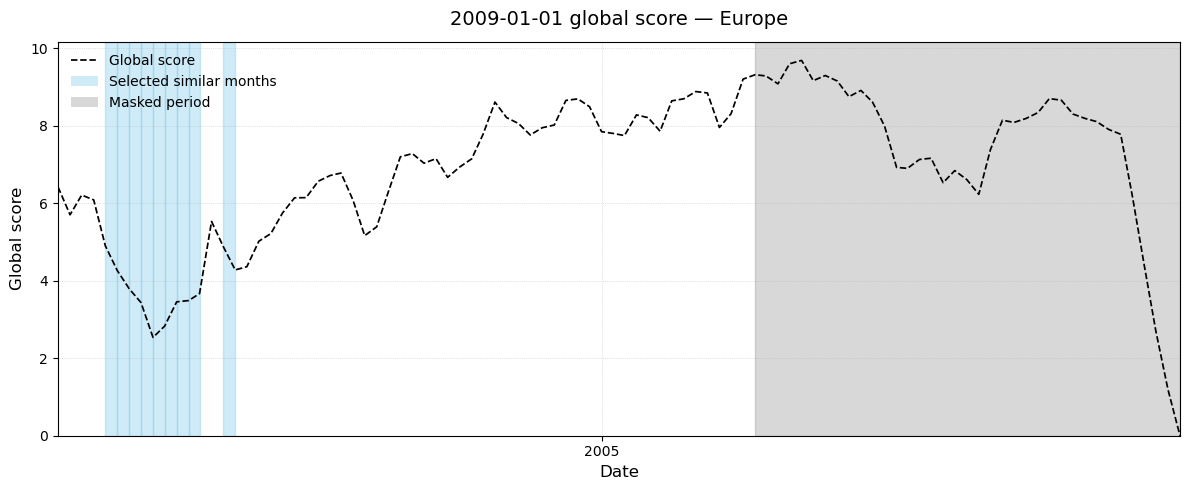

In [113]:
if "Month" in df_period_eur.columns:
    df_period_eur = df_period_eur.set_index("Month")


target_month   = "2009-01"   
bottom_pct     = 0.15        
exclude_last_n = 36         

sim_tbl_full = find_similar_months(
    df_period=df_period_eur,
    target=target_month,
    exclude_last_n=0,         
    bottom_pct=bottom_pct,
)

sim_tbl_masked = find_similar_months(
    df_period=df_period_eur,
    target=target_month,
    exclude_last_n=exclude_last_n,
    bottom_pct=bottom_pct,
)

ts_dist = (
    sim_tbl_full.set_index("Month")["Distance"]
                .sort_index()
                .rename("Global score")
)
ts_dist.index = ts_dist.index.to_timestamp(how="end")

selected = sim_tbl_masked[sim_tbl_masked["IsBottom"]].copy()
selected["start"] = selected["Month"].dt.to_timestamp(how="start")
selected["end"]   = selected["Month"].dt.to_timestamp(how="end")

T_period      = pd.Period(target_month, freq="M")
cutoff_period = T_period - exclude_last_n
mask_start_ts = (cutoff_period + 1).to_timestamp(how="start")
mask_end_ts   = T_period.to_timestamp(how="end")




plt.figure(figsize=(12, 5))
ax = plt.gca()

# main line
ax.plot(ts_dist.index, ts_dist.values,
        linestyle="--", color="black", linewidth=1.25,
        label="Global score")

for _, row in selected.iterrows():
    ax.axvspan(row["start"], row["end"], color="skyblue", alpha=0.4)

ax.axvspan(mask_start_ts, mask_end_ts, color="gray", alpha=0.3)

proxy_sim  = Rectangle((0, 0), 1, 1, facecolor="skyblue", alpha=0.4)
proxy_mask = Rectangle((0, 0), 1, 1, facecolor="gray",    alpha=0.3)
ax.legend(handles=[ax.lines[0], proxy_sim, proxy_mask],
          labels=["Global score",
                  "Selected similar months",
                  "Masked period"],
          loc="upper left", frameon=False)

ax.set_title(f"{target_month}-01 global score — Europe", fontsize=14, pad=12)
ax.set_ylabel("Global score", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylim(bottom=0)
ax.set_xlim(left=ts_dist.index.min(), right=ts_dist.index.max())
ax.grid(which="major", linestyle=":", linewidth=0.5, alpha=0.7)
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


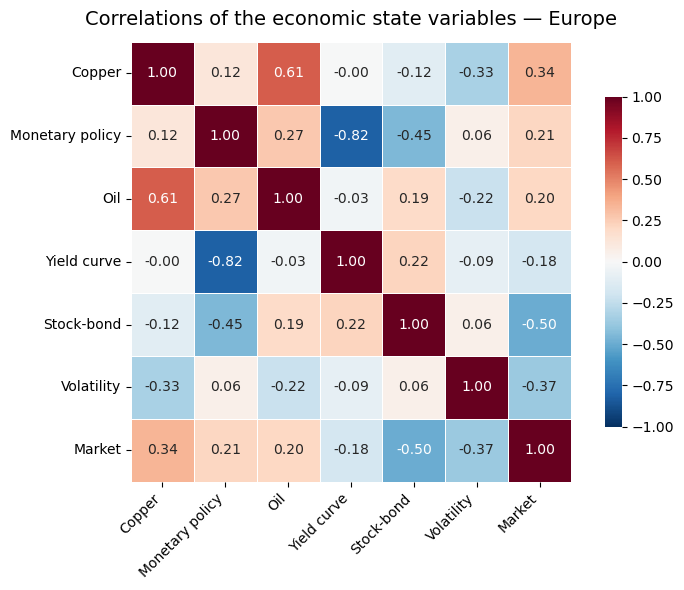

In [115]:

z_market  = (compute_z_and_winsorized(market_monthly_eur,      "Month", "Value")
             .rename(columns={"ZScoreWinsorized": "Market"})[["Month", "Market"]])

z_yield   = (compute_z_and_winsorized(yield_monthly_eur,       "Month", "Value")
             .rename(columns={"ZScoreWinsorized": "Yield curve"})[["Month", "Yield curve"]])

z_oil     = (compute_z_and_winsorized(oil_monthly_clean_eur,   "Month", "Value")
             .rename(columns={"ZScoreWinsorized": "Oil"})[["Month", "Oil"]])

z_copper  = (compute_z_and_winsorized(copper_monthly_clean_eur,"Month", "Value")
             .rename(columns={"ZScoreWinsorized": "Copper"})[["Month", "Copper"]])

z_3m      = (compute_z_and_winsorized(monthly_3m_eur,          "Month", "Value")
             .rename(columns={"ZScoreWinsorized": "Monetary policy"})[["Month", "Monetary policy"]])

z_vix     = (compute_z_and_winsorized(vix_monthly_clean_eur,   "Month", "Value")
             .rename(columns={"ZScoreWinsorized": "Volatility"})[["Month", "Volatility"]])

z_sb      = (compute_z_and_winsorized(stockbond_monthly_eur,   "Month", "Value")
             .rename(columns={"ZScoreWinsorized": "Stock-bond"})[["Month", "Stock-bond"]])

df_period_eur = (z_market
    .merge(z_yield, on="Month", how="outer")
    .merge(z_oil,   on="Month", how="outer")
    .merge(z_copper,on="Month", how="outer")
    .merge(z_3m,    on="Month", how="outer")
    .merge(z_vix,   on="Month", how="outer")
    .merge(z_sb,    on="Month", how="outer"))

corr_mat_eur = df_period_eur.drop(columns="Month").corr()

row_order = [
    "Copper",
    "Monetary policy",
    "Oil",
    "Yield curve",
    "Stock-bond",
    "Volatility",
    "Market",
]
corr_mat_eur = corr_mat_eur.loc[row_order, row_order]


plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_mat_eur,
    annot=True,
    fmt=".2f",
    center=0,
    cmap="RdBu_r",
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
)
plt.title("Correlations of the economic state variables — Europe", fontsize=14, pad=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [116]:
def find_similar_months(
    df_period: pd.DataFrame,
    target: str,
    exclude_last_n: int = 36,
    bottom_pct: float = 0.15
) -> pd.DataFrame:
    
    T_period = pd.Period(target, freq='M')

    
    cutoff_period = T_period - exclude_last_n  

    mask = df_period.index <= cutoff_period

    df_candidates = df_period.loc[mask].copy()

    df_candidates = df_candidates.dropna(how='any')

    z_T = df_period.loc[T_period].values   

    mat = df_candidates.values               
    diffs = mat - z_T.reshape(1, -1)        
    sq    = diffs**2
    dist  = np.sqrt(sq.sum(axis=1))          

    out = pd.DataFrame({
        'Distance': dist
    }, index=df_candidates.index)

    out = out.sort_values('Distance', ascending=True)
    out['Rank'] = np.arange(1, len(out) + 1)
    n_select = int(np.floor(bottom_pct * len(out)))
    n_select = max(n_select, 1)  
    out['IsBottom'] = False
    out.iloc[:n_select, out.columns.get_indexer(['IsBottom'])] = True

    result_df = out.reset_index().rename(columns={'index': 'Month'})

    return result_df

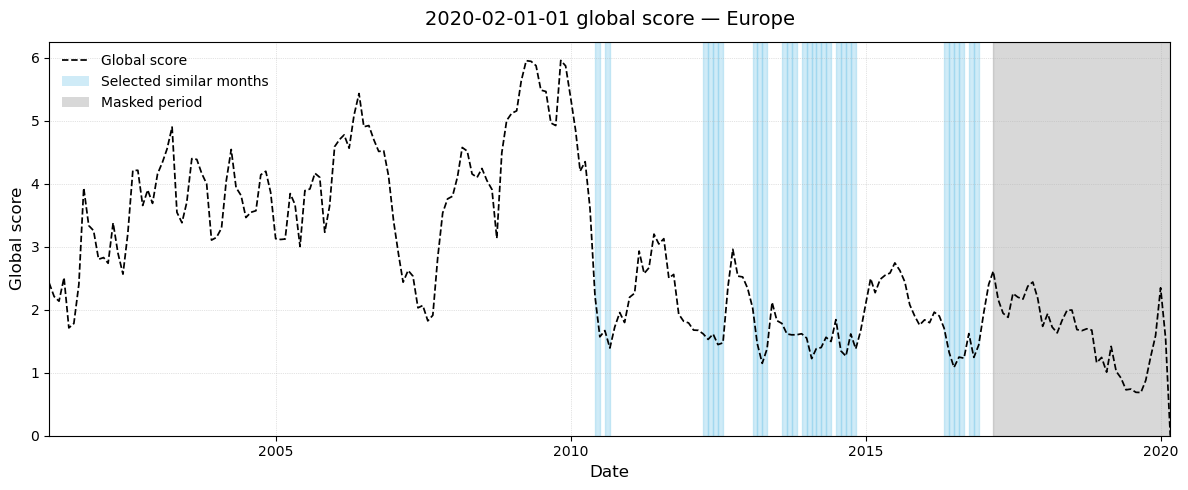

In [117]:
if "Month" in df_period_eur.columns:
    df_period_eur = df_period_eur.set_index("Month")

target_month   = "2020-02-01"  
bottom_pct     = 0.15        
exclude_last_n = 36          

sim_tbl_full = find_similar_months(
    df_period=df_period_eur,
    target=target_month,
    exclude_last_n=0,         
    bottom_pct=bottom_pct,
)

sim_tbl_masked = find_similar_months(
    df_period=df_period_eur,
    target=target_month,
    exclude_last_n=exclude_last_n,
    bottom_pct=bottom_pct,
)

ts_dist = (
    sim_tbl_full.set_index("Month")["Distance"]
                .sort_index()
                .rename("Global score")
)
ts_dist.index = ts_dist.index.to_timestamp(how="end")

selected = sim_tbl_masked[sim_tbl_masked["IsBottom"]].copy()
selected["start"] = selected["Month"].dt.to_timestamp(how="start")
selected["end"]   = selected["Month"].dt.to_timestamp(how="end")

T_period      = pd.Period(target_month, freq="M")
cutoff_period = T_period - exclude_last_n
mask_start_ts = (cutoff_period + 1).to_timestamp(how="start")
mask_end_ts   = T_period.to_timestamp(how="end")


plt.figure(figsize=(12, 5))
ax = plt.gca()

ax.plot(ts_dist.index, ts_dist.values,
        linestyle="--", color="black", linewidth=1.25,
        label="Global score")

for _, row in selected.iterrows():
    ax.axvspan(row["start"], row["end"], color="skyblue", alpha=0.4)

ax.axvspan(mask_start_ts, mask_end_ts, color="gray", alpha=0.3)

proxy_sim  = Rectangle((0, 0), 1, 1, facecolor="skyblue", alpha=0.4)
proxy_mask = Rectangle((0, 0), 1, 1, facecolor="gray",    alpha=0.3)
ax.legend(handles=[ax.lines[0], proxy_sim, proxy_mask],
          labels=["Global score",
                  "Selected similar months",
                  "Masked period"],
          loc="upper left", frameon=False)

ax.set_title(f"{target_month}-01 global score — Europe", fontsize=14, pad=12)
ax.set_ylabel("Global score", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylim(bottom=0)
ax.set_xlim(left=ts_dist.index.min(), right=ts_dist.index.max())
ax.grid(which="major", linestyle=":", linewidth=0.5, alpha=0.7)
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [126]:


ff_5f = pd.read_csv("Regimes\Data\Europe\Europe_5_Factors.csv",skiprows=3,engine='python').rename(columns={"Unnamed: 0": "Date"}) 
ff_mom = pd.read_csv("Regimes\Data\Europe\Europe_MOM_Factor.csv",skiprows=3,engine='python').rename(columns={"Unnamed: 0": "Date"}) 

In [127]:

concat_fff = (
    pd.merge(ff_5f, ff_mom, on="Date", how="inner")      # raw join
      .rename(columns={"WML": "Mom"})    # clarify cols
      .assign(Date=lambda d: d["Date"].astype(str).str.strip())# ensure str
      .loc[lambda d: d["Date"].str.fullmatch(r"\d{6}")]        # keep YYYYMM rows
)

concat_fff["Month"] = pd.to_datetime(concat_fff["Date"], format="%Y%m").dt.to_period("M")
concat_fff = concat_fff.set_index("Month").drop(columns="Date").sort_index()

factor_cols = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "Mom"]
concat_fff[factor_cols] = concat_fff[factor_cols].apply(pd.to_numeric, errors="coerce") / 100
concat_fff["RF"]        = pd.to_numeric(concat_fff["RF"], errors="coerce") / 100

print(concat_fff.head())



         Mkt-RF     SMB     HML     RMW     CMA      RF     Mom
Month                                                          
1991-07  0.0530 -0.0322 -0.0035  0.0271 -0.0049  0.0049  0.0506
1991-08  0.0142 -0.0096 -0.0008  0.0277  0.0021  0.0046  0.0377
1991-09  0.0302  0.0178 -0.0005  0.0270 -0.0053  0.0046  0.0423
1991-12  0.0630 -0.0385 -0.0210  0.0119 -0.0131  0.0038  0.0193
1992-04  0.0502 -0.0135 -0.0007  0.0261  0.0190  0.0032  0.0188


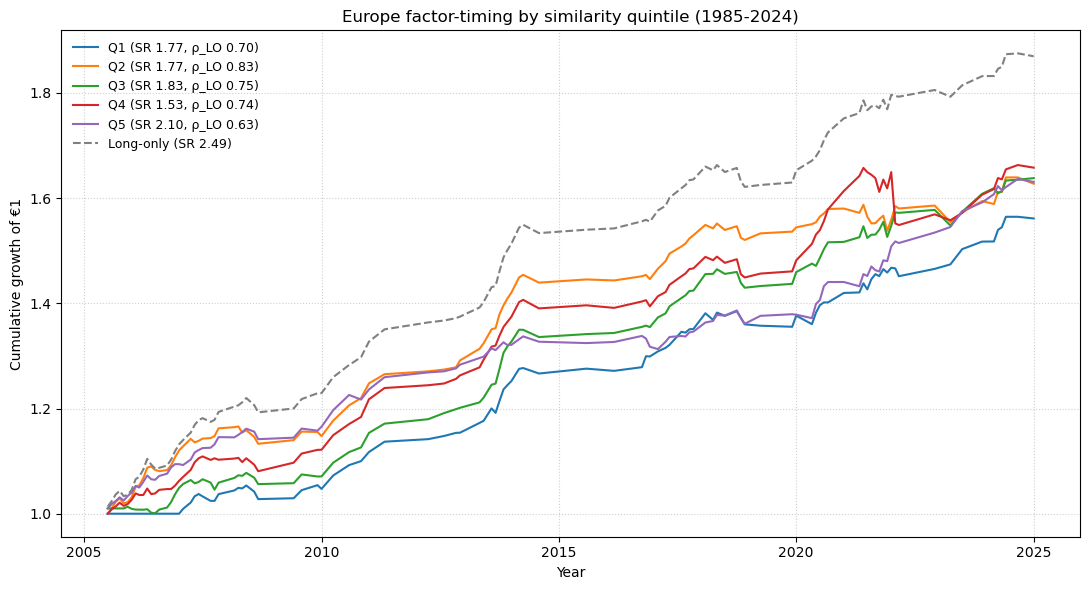

In [101]:
------------------------------------------------------

lookback_gap = 36                      
factors      = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom']
colors       = {1:"tab:blue", 2:"tab:orange", 3:"tab:green",
                4:"tab:red", 5:"tab:purple"}

BACKTEST_START = pd.Period('2005-01', freq='M')
BACKTEST_END   = pd.Period('2024-12', freq='M')

def quintile_members(df_period: pd.DataFrame, target_per: pd.Period):
    full = (find_similar_months(df_period, str(target_per),
                                exclude_last_n=lookback_gap,
                                bottom_pct=1.0)
            .sort_values('Distance'))

    n = len(full)
    if n == 0:
        return {q: np.array([]) for q in range(1, 6)}

    k20         = int(0.20 * n)
    q1          = full.iloc[:k20]['Month'].to_numpy()
    q5          = full.iloc[-k20:]['Month'].to_numpy()
    mid         = full.iloc[k20:-k20]['Month'].to_numpy()
    q2, q3, q4  = np.array_split(mid, 3)

    return {1: q1, 2: q2, 3: q3, 4: q4, 5: q5}

def signal_for_quintile(df_period, target_per, quintile):
    months = quintile_members(df_period, target_per)[quintile]
    if len(months) == 0:
        return {f: 0 for f in factors}

    idx   = pd.PeriodIndex(months, freq='M') + 1           
    signs = {}
    for f in factors:
        rets      = concat_fff.loc[concat_fff.index.intersection(idx), f]
        signs[f]  = np.sign(rets.mean()) if not rets.empty else 0
    return signs

first_possible = df_period_eur.index.min() + (lookback_gap + 1)
hist_start     = max(BACKTEST_START, first_possible)
hist_end       = min(BACKTEST_END,   concat_fff.index.max())

all_months = concat_fff.index.sort_values()
start_idx  = next(i for i, p in enumerate(all_months) if p >= hist_start)
stop_idx   = next(i for i, p in enumerate(all_months) if p >  hist_end) - 1

returns_by_q = {q: [] for q in range(1, 6)}

for i in range(start_idx, stop_idx):
    cur_per, nxt_per = all_months[i], all_months[i+1]
    r = concat_fff.loc[nxt_per, factors]

    for q in range(1, 6):
        sig = signal_for_quintile(df_period_eur, cur_per, q)
        ret = np.mean([sig[f] * r[f] for f in factors])
        returns_by_q[q].append({'Date': nxt_per, 'Return': ret})

q_df = {q: pd.DataFrame(lst).set_index('Date') for q, lst in returns_by_q.items()}


common_idx = q_df[1].dropna().index
for q in range(2, 6):
    common_idx = common_idx.intersection(q_df[q].dropna().index)

first_trd = common_idx.min()

for q in q_df:
    q_df[q] = q_df[q].loc[first_trd:]

long_only = (
    concat_fff[factors]
      .mean(axis=1)
      .loc[first_trd:]
      .reindex(q_df[1].index)       
      .dropna()
)



ann_sr  = lambda x: (x.mean() / x.std()) * np.sqrt(12) if x.std() != 0 else np.nan
corr_lo = lambda x: x.corr(long_only)

stats = {q: (ann_sr(df['Return']), corr_lo(df['Return'])) for q, df in q_df.items()}
sr_lo = ann_sr(long_only)

cum = lambda x: (1 + x).cumprod()

plt.figure(figsize=(11, 6))
for q in range(1, 6):
    plt.plot(q_df[q].index.to_timestamp(how='end'),
             cum(q_df[q]['Return']),
             color=colors[q],
             label=f"Q{q} (SR {stats[q][0]:.2f}, ρ_LO {stats[q][1]:.2f})")

plt.plot(q_df[1].index.to_timestamp(how='end'),
         cum(long_only), color='gray', ls='--',
         label=f"Long-only (SR {sr_lo:.2f})")

plt.title("Europe factor-timing by similarity quintile (1985-2024)")
plt.xlabel("Year")
plt.ylabel("Cumulative growth of €1")
plt.legend(frameon=False, fontsize=9)
plt.grid(ls=":", alpha=.6)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()


In [104]:
import numpy as np
import pandas as pd
from numpy.linalg import inv, LinAlgError

def find_similar_months_maha(
    df_period: pd.DataFrame,
    target: str,
    exclude_last_n: int = 36,
    bottom_pct: float = 0.15,
    ridge: float = 1e-8        
) -> pd.DataFrame:
    """
    Same signature / output as the Euclidean version, but uses
    Mahalanobis distance:  d(i) = √((x_i – x_T)^T Σ⁻¹ (x_i – x_T))
    where Σ is the sample covariance matrix of the candidate set.
    """
    T_period = pd.Period(target, freq="M")

    cutoff_period = T_period - exclude_last_n
    df_candidates = (df_period
                     .loc[df_period.index <= cutoff_period]
                     .dropna(how="any")
                     .copy())

    if df_candidates.empty:
        raise ValueError("No candidate months left after masking NA / look-back.")

    X = df_candidates.values
    try:
        inv_cov = inv(np.cov(X, rowvar=False))
    except LinAlgError:
        Σ = np.cov(X, rowvar=False)
        Σ += ridge * np.eye(Σ.shape[0])
        inv_cov = inv(Σ)

    x_T = df_period.loc[T_period].values.reshape(1, -1)
    diffs = X - x_T                             # (n, k)
    d2    = np.einsum("ij,jk,ik->i", diffs, inv_cov, diffs)  # quadratic form
    dist  = np.sqrt(d2)

    out = (pd.DataFrame({"Distance": dist}, index=df_candidates.index)
             .sort_values("Distance"))
    out["Rank"] = np.arange(1, len(out) + 1)

    n_select = max(int(np.floor(bottom_pct * len(out))), 1)
    out["IsBottom"] = False
    out.iloc[:n_select, out.columns.get_loc("IsBottom")] = True

    return out.reset_index().rename(columns={"index": "Month"})


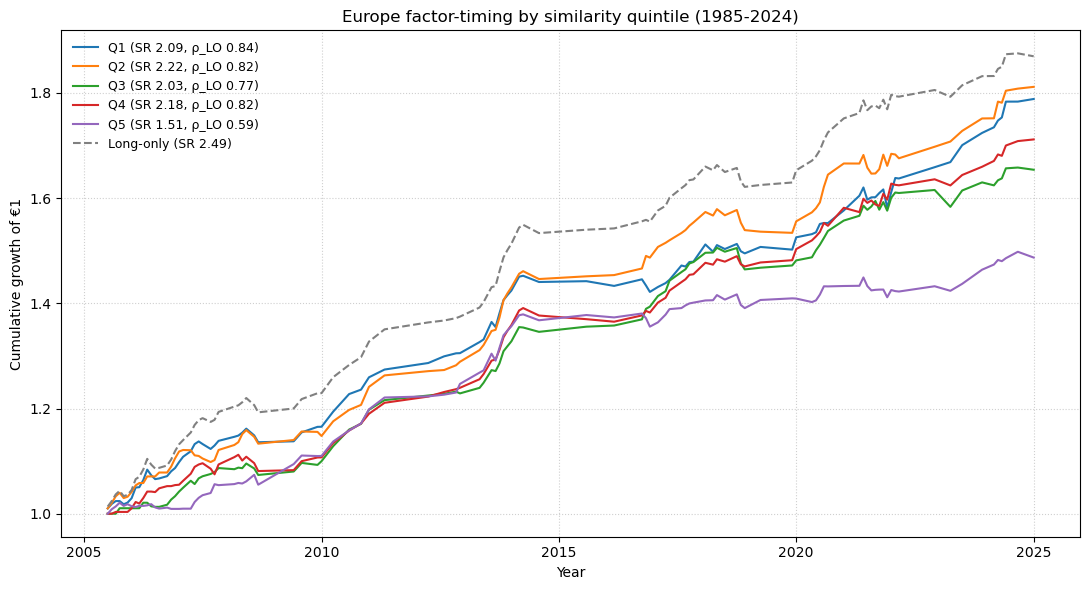

In [105]:
lookback_gap = 36                      
factors      = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom']
colors       = {1:"tab:blue", 2:"tab:orange", 3:"tab:green",
                4:"tab:red", 5:"tab:purple"}

BACKTEST_START = pd.Period('2005-01', freq='M')
BACKTEST_END   = pd.Period('2024-12', freq='M')

def quintile_members(df_period: pd.DataFrame, target_per: pd.Period):
    full = (find_similar_months_maha(df_period, str(target_per),
                                exclude_last_n=lookback_gap,
                                bottom_pct=1.0)
            .sort_values('Distance'))

    n = len(full)
    if n == 0:
        return {q: np.array([]) for q in range(1, 6)}

    k20         = int(0.20 * n)
    q1          = full.iloc[:k20]['Month'].to_numpy()
    q5          = full.iloc[-k20:]['Month'].to_numpy()
    mid         = full.iloc[k20:-k20]['Month'].to_numpy()
    q2, q3, q4  = np.array_split(mid, 3)

    return {1: q1, 2: q2, 3: q3, 4: q4, 5: q5}

def signal_for_quintile(df_period, target_per, quintile):
    months = quintile_members(df_period, target_per)[quintile]
    if len(months) == 0:
        return {f: 0 for f in factors}

    idx   = pd.PeriodIndex(months, freq='M') + 1      
    signs = {}
    for f in factors:
        rets      = concat_fff.loc[concat_fff.index.intersection(idx), f]
        signs[f]  = np.sign(rets.mean()) if not rets.empty else 0
    return signs

first_possible = df_period_eur.index.min() + (lookback_gap + 1)
hist_start     = max(BACKTEST_START, first_possible)
hist_end       = min(BACKTEST_END,   concat_fff.index.max())

all_months = concat_fff.index.sort_values()
start_idx  = next(i for i, p in enumerate(all_months) if p >= hist_start)
stop_idx   = next(i for i, p in enumerate(all_months) if p >  hist_end) - 1

returns_by_q = {q: [] for q in range(1, 6)}

for i in range(start_idx, stop_idx):
    cur_per, nxt_per = all_months[i], all_months[i+1]
    r = concat_fff.loc[nxt_per, factors]

    for q in range(1, 6):
        sig = signal_for_quintile(df_period_eur, cur_per, q)
        ret = np.mean([sig[f] * r[f] for f in factors])
        returns_by_q[q].append({'Date': nxt_per, 'Return': ret})

q_df = {q: pd.DataFrame(lst).set_index('Date') for q, lst in returns_by_q.items()}

common_idx = q_df[1].dropna().index
for q in range(2, 6):
    common_idx = common_idx.intersection(q_df[q].dropna().index)

first_trd = common_idx.min()

for q in q_df:
    q_df[q] = q_df[q].loc[first_trd:]

long_only = (
    concat_fff[factors]
      .mean(axis=1)
      .loc[first_trd:]
      .reindex(q_df[1].index)       
      .dropna()
)



ann_sr  = lambda x: (x.mean() / x.std()) * np.sqrt(12) if x.std() != 0 else np.nan
corr_lo = lambda x: x.corr(long_only)

stats = {q: (ann_sr(df['Return']), corr_lo(df['Return'])) for q, df in q_df.items()}
sr_lo = ann_sr(long_only)

cum = lambda x: (1 + x).cumprod()

plt.figure(figsize=(11, 6))
for q in range(1, 6):
    plt.plot(q_df[q].index.to_timestamp(how='end'),
             cum(q_df[q]['Return']),
             color=colors[q],
             label=f"Q{q} (SR {stats[q][0]:.2f}, ρ_LO {stats[q][1]:.2f})")

plt.plot(q_df[1].index.to_timestamp(how='end'),
         cum(long_only), color='gray', ls='--',
         label=f"Long-only (SR {sr_lo:.2f})")

plt.title("Europe factor-timing by similarity quintile (1985-2024)")
plt.xlabel("Year")
plt.ylabel("Cumulative growth of €1")
plt.legend(frameon=False, fontsize=9)
plt.grid(ls=":", alpha=.6)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()